In [1]:
!apt update
!apt install -y graphviz

Hit:1 http://deb.debian.org/debian bookworm InRelease
Hit:2 http://deb.debian.org/debian bookworm-updates InRelease
Hit:3 http://deb.debian.org/debian-security bookworm-security InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
All packages are up to date.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-7+deb12u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
import polars as pl

In [3]:
# レシピ50, 51で利用する巨大データの生成、１分ほどかかる
import random

random.seed(42)

pl.DataFrame(
    {
        "col1": [random.randint(0, 10**5) for _ in range(10**7)],
        "col2": [random.randint(0, 10**5) for _ in range(10**7)],
        "col3": [random.randint(0, 10**5) for _ in range(10**7)],
        "col4": [random.randint(0, 10**5) for _ in range(10**7)],
        "col5": [random.randint(0, 10**5) for _ in range(10**7)],
    }
).write_csv("./numeric_data.csv")

In [4]:
def my_range(n):
    num = 0
    while num < n:
        yield num
        num += 1

In [5]:
range1 = range(10)
range2 = my_range(10)

print('range1')
for i in range1:
    print(i)

print('range2')
for i in range2:
    print(i)

print('range1')
for i in range1:
    print(i)

print('range2')
for i in range2:
    print(i)

range1
0
1
2
3
4
5
6
7
8
9
range2
0
1
2
3
4
5
6
7
8
9
range1
0
1
2
3
4
5
6
7
8
9
range2


In [6]:
lf = pl.scan_csv('numeric_data.csv')
lf.collect().head()

col1,col2,col3,col4,col5
i64,i64,i64,i64,i64
83810,80509,23964,43796,26049
14592,7086,78349,48333,65814
3278,79047,20068,13022,12634
97196,33410,78819,25977,54157
36048,45832,60030,60793,53155


In [7]:
lf_agg = (
    lf
    .with_columns((pl.col('col1') * 2).alias('double_col1'))
    .with_columns((pl.col('col2') + 5).alias('plus5_col2'))
    .filter(pl.col('double_col1') > 10000)
    .group_by(['plus5_col2'])
    .agg(pl.col('col3').sum().alias('sum_col3'))
    .filter(pl.col('sum_col3') > 500000)
    .select(['plus5_col2', 'sum_col3'])
    .head(100)
)

In [8]:
lf_agg.collect()

plus5_col2,sum_col3
i64,i64
15095,4527308
89411,4341370
51787,4508468
71309,4567112
35394,5081295
…,…
63449,4004721
36070,4425522
25828,4771989


In [9]:
lf_agg

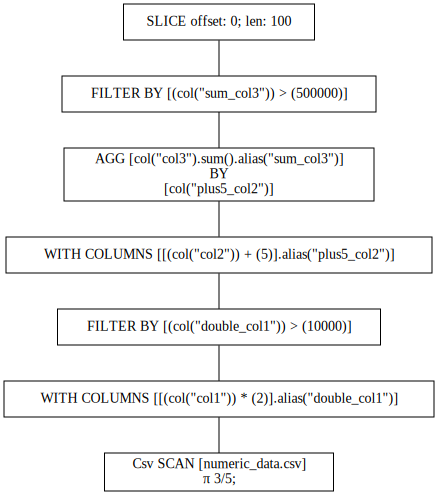

In [10]:
lf_agg.show_graph(optimized=True)

In [11]:
print(lf_agg.explain(optimized=False))

SLICE[offset: 0, len: 100]
   SELECT [col("plus5_col2"), col("sum_col3")] FROM
    FILTER [(col("sum_col3")) > (500000)] FROM
      AGGREGATE
      	[col("col3").sum().alias("sum_col3")] BY [col("plus5_col2")] FROM
        FILTER [(col("double_col1")) > (10000)] FROM
           WITH_COLUMNS:
           [[(col("col2")) + (5)].alias("plus5_col2")] 
             WITH_COLUMNS:
             [[(col("col1")) * (2)].alias("double_col1")] 
              Csv SCAN [numeric_data.csv]
              PROJECT */5 COLUMNS


In [12]:
print(lf_agg.explain(optimized=True))

SLICE[offset: 0, len: 100]
  FILTER [(col("sum_col3")) > (500000)] FROM
    AGGREGATE
    	[col("col3").sum().alias("sum_col3")] BY [col("plus5_col2")] FROM
       WITH_COLUMNS:
       [[(col("col2")) + (5)].alias("plus5_col2")] 
        FILTER [(col("double_col1")) > (10000)] FROM
           WITH_COLUMNS:
           [[(col("col1")) * (2)].alias("double_col1")] 
            Csv SCAN [numeric_data.csv]
            PROJECT 3/5 COLUMNS


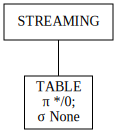

In [13]:
lf_agg.show_graph(streaming=True)

In [14]:
lf_agg.collect(streaming=True)

plus5_col2,sum_col3
i64,i64
97014,4498644
9178,4891684
3640,5230685
63032,4638154
75788,5570301
…,…
45954,4381834
52944,5927513
86093,4930283
